In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [1]:
import numpy as np

file = np.load("../data/cloudless/adwp/B11.npz")

In [227]:
%%file ../cloud_seg/models/cloudmix/cloud_mlp.py
"""
Train MLP to match cloudless versions of images to cloudy ones
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
# from torch.optim import Adam

import numpy as np

import matplotlib.pyplot as plt
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

class LitMLP(pl.LightningModule):

    def __init__(self, data, labels, val_frac=0.25, batch_size=64, learning_rate=1e-1):
        super().__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.num_bands = data.shape[1]
        self.learning_rate = learning_rate            
        self.batch_size=batch_size
       
        
        self.fc1 = nn.Linear(self.num_bands, 12)
        self.fc2 = nn.Linear(12, 8)
        self.fc3 = nn.Linear(8, self.num_bands)

        # self.fc1 = nn.Linear(self.num_bands, 8)
        # self.fc2 = nn.Linear(8, self.num_bands)

        # self.fc1 = nn.Linear(self.num_bands, self.num_bands)

        nsamples = data.shape[0]
        inds = np.arange(nsamples)
        np.random.shuffle(inds)
        
        ind_split = int(nsamples*(1-val_frac))
        self.train_data = data[inds[:ind_split]]
        self.train_labels = labels[inds[:ind_split]]
        
        self.val_data = data[inds[ind_split:]]
        self.val_labels = labels[inds[ind_split:]]

        self.train_dataset = MLPDataset(self.train_data, self.train_labels)
        self.val_dataset = MLPDataset(self.val_data, self.val_labels)

        # self.criteria = nn.L1Loss()
    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        # x = self.fc1( x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = F.mse_loss(preds, y)
        # loss = self.criteria(preds, y)

        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = F.mse_loss(preds, y)
        self.log("val_loss", loss)
        return loss
       
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        # optimizer = torch.optim.LBFGS(self.parameters(), lr=self.learning_rate)

        # scheduler = torch.optim.lr_scheduler.ExponentialLR(
        #         optimizer,
        #         gamma=0.99,
        #     )
        return optimizer
        # return [optimizer], [scheduler]

    def train_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
        )
    
    def val_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
        ) 
    
class MLPDataset(torch.utils.data.Dataset):
    """Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """

    def __init__(self, data, labels):
    
        self.data  = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        # Loads an n-channel image from a chip-level dataframe
        return self.data[idx], self.labels[idx]



Overwriting ../cloud_seg/models/cloudmix/cloud_mlp.py


In [3]:
%%file ../cloud_seg/models/cloudmix/cloud_match.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.optim import Adam
import numpy as np
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from .cloud_mlp import LitMLP

def train_mlp(image_cloudless, image_cloudy, cloud_label, params, cloudfrac_max=0.9, sigma_smooth=10):
    """
    Trains an MLP on non-cloud pixels to map cloudless_image to cloudy_image
    """
    
    val_frac = 0.25
    max_epochs = 10
    learning_rate = 5e-2
    batch_size = 4096

    cloud_use = gaussian_filter(cloud_label.astype(np.float32), sigma=sigma_smooth)
    cloud_use = ((cloud_use > 0.05)*1).astype(np.uint8)
    
    if np.mean(cloud_use) > cloudfrac_max:
        return image_cloudless
    
    # images come in as list of arrays, so convert to array and flatten
    x = np.stack([v for k,v in sorted(image_cloudless.items())], -1)
    y = np.stack([v for k,v in sorted(image_cloudy.items())], -1)

    x = x.reshape(-1, x.shape[-1])
    y = y.reshape(-1, y.shape[-1])
    dm = cloud_use.reshape(-1)


    x_train = torch.tensor(x[dm==0])
    y_train = torch.tensor(y[dm==0])

    model = LitMLP(
        x_train,
        y_train,
        batch_size=batch_size,
        val_frac=val_frac,
        learning_rate=learning_rate,
    )

    pl.seed_everything(13579)

    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=0.00,
        patience=3,
        verbose=False,
        mode="min")
    
    trainer = pl.Trainer(
        gpus=1,
        max_epochs=max_epochs,
        callbacks=[early_stop_callback],
    )
    trainer.fit(model)

    x = torch.tensor(x)
    matched_cloudless_image = model(x).detach().numpy().reshape(512, 512, -1)
    
    # convert from array back to list
    cloudless_image = {}
    for iband, band in enumerate(params['bands_use']):
        cloudless_image[band] = matched_cloudless_image[..., iband]
            
    return cloudless_image

def find_and_return_most_similar_image(params, image, label, images_cloudless, brightness_correct_image='mlp'):
    """Given a cloudy chip and a number of cloudless versions of the same area, choose or create 
    the most similar one to the cloudy chip.
    
    The simple approximation is to just calculate which set of images best matches in regions where labels==0. 
    This does not accound for shadows.
    """
    
     # determine which new cloudless image is most similar to the old
     # by calculating agreement in non-cloudy regions
    diffs = np.zeros( (len(params['bands_use']), images_cloudless['B02'].shape[0]) )
    for i, band in enumerate(params['bands_use']):

        diff = (image[band]-images_cloudless[band]) * label
        diffs[i] = np.sum(diff, axis=(1,2))

        if diffs[i].max() > 0.:
            # if totally cloud covered label==0 everywhere, and max will be 0.
            diffs[i] /= diffs[i].max()

    total_diffs = np.mean(diffs, axis=0)

    ind_min_band_diff = np.argmin(total_diffs)  
    
    image_cloudless = {}
    for band in params['bands_use']:
        image_cloudless[band] = images_cloudless[band][ind_min_band_diff]
    
        if brightness_correct_image=='median':
            # try to match the average intensity in non cloudy regions
            dm = label == 0

            if np.sum(dm) > 0:
                mean_diff = np.median(image[band][dm] - image_cloudless[band][dm])
            else:
                mean_diff = 1.

            # print('mean_diff', mean_diff)
            images_cloudless[band] += mean_diff

    if brightness_correct_image=='mlp':
            
        if np.mean(label) > 0.:
            # Train MLP on non-cloudy portions of images, to better match cloudless to cloudy
            image_cloudless = train_mlp(image_cloudless, image, label, params, cloudfrac_max=0.9)  
        
     
    return image_cloudless

def extract_clouds(params, image, label, images_cloudless, cloud_extract_model='opacity'):
    """Given cloudy image/label pair, and 'cloudless' images of the same area pulled from the planetary computer,
    extract brightness changes due to clouds.
    
    First find "most similar" cloudless image to the cloudy one
    
    The simplest model is to assume clouds simply add brightness to each pixel that they cover. 
    If true, assuming that the land does not change between when the cloudy and cloudless images were taken,
    clouds = (images - images_cloudless)*labels.
    
    Unfortunately, both of these assumptions are incorrect
    
    1.) The cloudy and cloudless images are of the same location, but are often seperated by months or years.
        Over this timeframe plants change color, water levels change, and human infrastructure near cities changes.
        Additionally, the images might not be taken from the same angle, causing mis-alignments between each image set.
        
    2.) Clouds are sometimes transparent, sometimes not. An additive model does not correcely account for this
    
    3.) Cloud shadows... We know what angle the sun makes for each chip (in chip properties) can we come up with a way to project these?
    
    """
    cloud_extract_models = ['additive', 'opacity'] # Add transparency later
    
    if cloud_extract_model not in cloud_extract_models:
        print(f"WARNING: cloud model {cloud_extract_model} is not a possible value to use. Using {cloud_extract_models[0]} instead \
            Possible choices are:", cloud_extract_models)
        
    image_cloudless = find_and_return_most_similar_image(params, image, label, images_cloudless)   
    
    # and save to disk as .tif
    clouds = {}

    if cloud_extract_model=='additive':
        
        for band in params['bands_use']:
            clouds[band] = (image[band] - image_cloudless[band]) 

        opacity_mask = np.zeros_like(clouds[band], dtype=np.uint8)
        
    if cloud_extract_model=='opacity':
        # calculate per pixel luminence
        min_opacity_luminence = 5000.
        
        luminence = np.mean(
            np.stack(
                [image['B02'],image['B03'],image['B04'], image['B08']],
                axis=-1,
            ),
            axis=-1,
        )
        
        opacity_mask = luminence > min_opacity_luminence
        for band in params['bands_use']:
            clouds_in_band = np.zeros_like(image['B02'], dtype=image['B02'].dtype)

            clouds_in_band[opacity_mask] = image[band][opacity_mask] 
            clouds_in_band[~opacity_mask] = (image[band] - image_cloudless[band])[~opacity_mask] 

            clouds[band] = clouds_in_band
        
    return image_cloudless, clouds, ((opacity_mask > 0.5)*1).astype(np.uint8)


    

Overwriting ../cloud_seg/models/cloudmix/cloud_match.py


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 60    
1 | fc2  | Linear | 104   
2 | fc3  | Linear | 36    
--------------------------------
200       Trainable params
0         Non-trainable params
200       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 13579


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

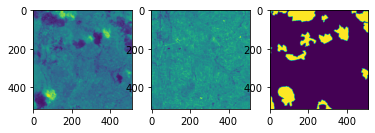

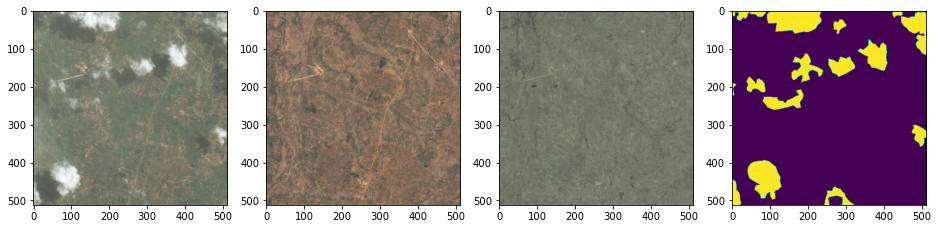

In [218]:
from scipy.ndimage import gaussian_filter

def get_array(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return im_arr

val_frac = 0.25
batch_size = 4096
max_epochs = 10
lrning_rate = 5e-2

DATA_DIR = Path.cwd().parent.resolve() / "data/"
DATA_DIR_CLOUDLESS_MOST_SIMILAR = DATA_DIR / 'cloudless_most_similar/'

TRAIN_FEATURES = DATA_DIR / "train_features/"
TRAIN_LABELS = DATA_DIR / "train_labels/"

bands_use = ['B02', 'B03', 'B04', 'B08']

chip_ids = ['adwp']#, 'adwu', 'adwz']
# chip_ids = ['afej', 'afyo', 'afys']
# chip_ids = ['afyo']
chip_ids = ['aejp']
for chip_id in chip_ids:

    cloudy_image = np.zeros((512, 512, len(bands_use)), dtype=np.float32)
    cloudless_image = np.zeros((512, 512, len(bands_use)), dtype=np.float32)
    for iband, band in enumerate(bands_use):
        cloudy_image[..., iband] = get_array(TRAIN_FEATURES / f"{chip_id}/{band}.tif")
        cloudless_image[..., iband] = get_array(DATA_DIR_CLOUDLESS_MOST_SIMILAR / f"{chip_id}/{band}.tif")

    cloud_label = get_array(TRAIN_LABELS / f"{chip_id}.tif")
    #smooth label
#     cloud_label = gaussian_filter(cloud_label.astype(np.float32), sigma=20)
#     cloud_label = ((cloud_label > 0.05)*1).astype(np.uint8)
    
    if np.mean(cloud_label) > 0.9:
        continue
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(cloudy_image[..., -1])
    ax[1].imshow(cloudless_image[..., -1])
    ax[2].imshow(cloud_label)

    x = cloudless_image.reshape(-1, cloudy_image.shape[-1])
    y = cloudy_image.reshape(-1, cloudy_image.shape[-1])
    dm = cloud_label.reshape(-1)

    x_train = torch.tensor(x[dm==0])
    y_train = torch.tensor(y[dm==0])


    # x = torch.unsqueeze(torch.linspace(-1, 1, nsamples), dim=1)  # x data (tensor), shape=(100, 1)
    # y = x + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)
    # # y = x.pow(2) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

    model = LitMLP(x_train, y_train, batch_size=batch_size, val_frac=val_frac, learning_rate=learning_rate)
    # datamodule = MLPDataModule(x, y, val_frac=val_frac, batch_size=batch_size)

    # pl.seed_everything(13579)

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=10, verbose=False, mode="min")
    trainer = pl.Trainer(max_epochs=max_epochs, callbacks=[early_stop_callback])
    trainer.fit(model)

    # model(x)
    x = torch.tensor(x)
    ypred = model(x).detach().numpy().reshape(512, 512, -1)

    def true_color(image_array):
        r = true_color_band(image_array[..., 2])
        g = true_color_band(image_array[..., 1])
        b = true_color_band(image_array[..., 0])

        return np.stack([r,g,b], axis=-1).astype(np.uint8)

    fig, ax = plt.subplots(1,4, figsize=(16,4))
    ax[0].imshow(true_color(cloudy_image))
    ax[1].imshow(true_color(cloudless_image))
    ax[2].imshow(true_color(ypred))
    ax[3].imshow(cloud_label)


float32 float32
-3811.0 2943.0


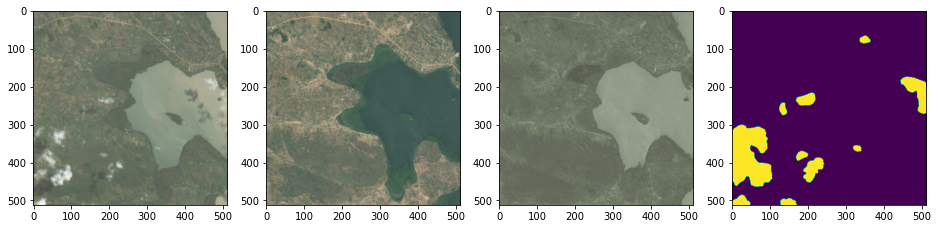

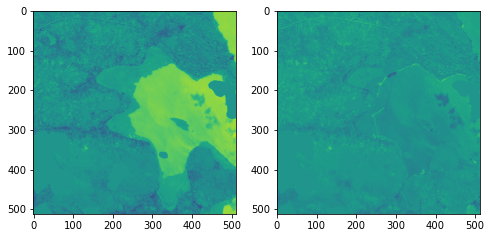

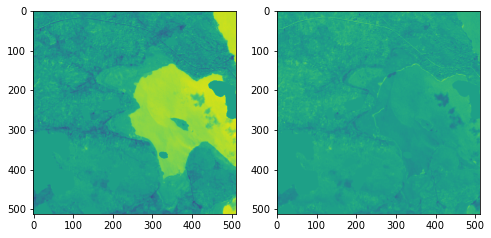

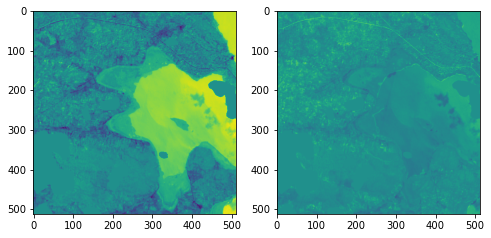

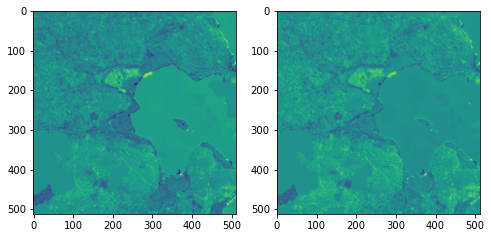

In [109]:
fig, ax = plt.subplots(1,4, figsize=(16,4))
ax[0].imshow(true_color(cloudy_image))
ax[1].imshow(true_color(cloudless_image))
ax[2].imshow(true_color(ypred))
ax[3].imshow(cloud_label)

print(cloudy_image.dtype, cloudless_image.dtype)
orig_diff = cloudy_image - cloudless_image
mlp_diff = cloudy_image - ypred
    

print(ymin, ymax)

for i in range(orig_diff.shape[-1]):
    ymin = min(np.min(orig_diff[..., i]*(1-cloud_label)), np.min(mlp_diff[..., i]*(1-cloud_label)))
    ymax = max(np.max(orig_diff[..., i]*(1-cloud_label)), np.max(mlp_diff[..., i]*(1-cloud_label)))
    
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].imshow(orig_diff[..., i]*(1-cloud_label), vmin=ymin, vmax=ymax)
    ax[1].imshow(mlp_diff[..., i]*(1-cloud_label), vmin=ymin, vmax=ymax)

In [150]:
def true_color_band(band_data, nodata=1, pixel_max=255, c=10., th=0.125):
    """
    Normalize band with:    
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)
    range_val = max_val - min_val
    
    out = (data.astype(np.float32) - min_val)/range_val
    out = 1. / (1. + np.exp(c * (th - out)))
    
    Copied from https://xarray-spatial.org/_modules/xrspatial/multispectral.html#true_color
    """
    # a = np.where(np.logical_or(np.isnan(r), r <= nodata), 0, 255)
    pixel_max = 255

    # h, w = band_data.shape
    # out = np.zeros((h, w, 4), dtype=np.uint8)
    # out[:, :, 0] = (normalize_data_numpy(r, pixel_max, c, th)).astype(np.uint8)
    # out[:, :, 1] = (normalize_data_numpy(g, pixel_max, c, th)).astype(np.uint8)
    # out[:, :, 2] = (normalize_data_numpy(b, pixel_max, c, th)).astype(np.uint8)
    
    out = normalize_data_xrspatial(band_data, pixel_max, c, th) #).astype(np.uint8)

    return out

def normalize_data_xrspatial(data, pixel_max, c, th):
    """
    Copied from https://xarray-spatial.org/_modules/xrspatial/multispectral.html#true_color
    """
    # min_val = np.nanmin(data)
    # max_val = np.nanmax(data)
    min_val = 0
    max_val = 10000
    data = np.clip(data, min_val, max_val)
    
    range_val = max_val - min_val
    out = (data.astype(np.float32) - min_val)/range_val
    out = 1. / (1. + np.exp(c * (th - out)))
    
    return out * pixel_max



In [74]:
%%file ../scripts/make_cloudbank.py
"""
Script to:

1.) extract clouds from pairs of cloudy/cloudless images.
    use flag --extract_clouds
    
2.) Make folder full of cloudless .tif chips from .npz arrays.
    use flag --save_cloudless_as_tif
    
3.) Make cloudbank dataframe to feed to pytorch dataloader for model training.
"""
import numpy as np
import pandas as pd
import pandas_path as path
from pathlib import Path
from PIL import Image
import glob
import argparse
import os

import multiprocessing
import subprocess
import skimage.transform as st

from cloud_seg.utils import utils
from cloud_seg.io import io
from cloud_seg.models.cloudmix import cloud_mlp
from cloud_seg.models.cloudmix import cloud_match

DATA_DIR = Path.cwd().parent.resolve() / "data/"
DATA_DIR_CLOUDS = DATA_DIR / 'clouds/'
DATA_DIR_CLOUDLESS = DATA_DIR / 'cloudless/'
DATA_DIR_CLOUDLESS_MOST_SIMILAR = DATA_DIR / 'cloudless_most_similar/'
DATA_DIR_CLOUDLESS_TIF = DATA_DIR / 'cloudless_tif/'
DATA_DIR_OUT = DATA_DIR / "model_training/"

TRAIN_FEATURES = DATA_DIR / "train_features/"
TRAIN_FEATURES_NEW = DATA_DIR / "train_features_new/"

TRAIN_LABELS = DATA_DIR / "train_labels/"

IMAGE_OUTSIZE = [512, 512]
INTERPOLATION_ORDER = 0

assert TRAIN_FEATURES.exists(), TRAIN_LABELS.exists()

Path(DATA_DIR_OUT).mkdir(parents=True, exist_ok=True)
Path(DATA_DIR_CLOUDS).mkdir(parents=True, exist_ok=True)


parser = argparse.ArgumentParser(description='runtime parameters')
parser.add_argument("--bands", nargs='+' , default=["B02", "B03", "B04", "B08"],
                    help="bands desired")

parser.add_argument("--bands_new", nargs='+', default=None,
                    help="additional bands to use beyond original four")

parser.add_argument("-ncv", "--num_cross_validation_splits", type=int, default=5,
                    help="fraction of data to put in validation set") 

parser.add_argument("--save_cloudless_as_tif", action="store_true",
                    help="For each cloudless chip save array of band data (Nimg, H, W) as invididual .tif files") 

parser.add_argument("--extract_clouds", action="store_true",
                    help="Extract clouds from pairs of cloudy and cloudless chips") 

parser.add_argument("--cloud_extract_model", type=str, default='opacity',
                    help="Cloud model to use", choices=['opacity', 'additive']) 

parser.add_argument("--frac_all_cloud_keep", type=float, default=0.1,
                    help="Fraction of total cloud cover cloud chips to keep") 

parser.add_argument("--remake_all", action="store_true",
                    help="Remake all images, and overwrite current ones on disk")

parser.add_argument("--max_pool_size", type=int, default=64,
                help="number of pooling threads to use")

parser.add_argument("--interpolation_order", type=int, default=0,
                    help="interpolation order for resizing images") 

parser.add_argument("--seed", type=int , default=13579,
                    help="random seed for train test split")

parser.add_argument("--dont_save_to_disk", action="store_true",
                    help="save training and validation sets to disk")  

parser.add_argument("-v", "--verbose", action="store_true",
                    help="increase output verbosity")

params = vars(parser.parse_args())
params['bands_use'] = sorted(params['bands'] + params['bands_new']) if params['bands_new'] is not None else params['bands']

params['outsize'] = [512, 512]

if params['verbose']: print("Parameters are: ", params)
    
def construct_cloudbank_dataframe(df_val, params: dict):
    """Construct cloudbank using all chips that do not overlap with validation set"""
    np.random.seed(params['seed'])
    
    cloud_chips = sorted(glob.glob(str(DATA_DIR_CLOUDS) + '/*'))
    
    # Check that files exist in directory
    cloud_chips = [i for i in cloud_chips if os.path.isfile(os.path.join(i,'B04.tif'))] 
    print(f"\nTotal number of cloud chips is {len(cloud_chips)}")

    # remove cloud chips that are from validation sample
    in_val = [os.path.basename(i) in df_val['chip_id'].to_numpy() for i in cloud_chips]
    cloud_chips = [chip for ichip, chip in enumerate(cloud_chips) if not in_val[ichip]] 
    print(f"\nTotal number of cloud chips not overlapping validation chips is {len(cloud_chips)}")

    # Get label stats to use to remove certain chips
    labels_mean = np.array([np.mean(np.array(Image.open(os.path.join(chip_dir, 'label.tif')))) for chip_dir in cloud_chips])
    cloud_chips = np.array(cloud_chips)
    
    # Remove cloud chips where mean(label)==0 (these are not cloud chips anyways)
    dm_no_cloud = labels_mean == 0.

    # subsample chips where mean(label)==1
    dm_all_cloud = labels_mean == 1.
    all_cloud_chips = np.random.choice(
        cloud_chips[dm_all_cloud],
        int(np.sum(dm_all_cloud) * params['frac_all_cloud_keep']),
        replace=False,
    )

    cloud_chips = list(cloud_chips[~dm_no_cloud & ~dm_all_cloud])
    cloud_chips += list(all_cloud_chips)
    
    print(f"\nTotal number of cloud chips after removing selected is {len(cloud_chips)}")

    cloudbank = []
    for chip in cloud_chips:
        # for each location choose an image 
        chip_id = os.path.basename(chip)
        # print(chip, chip_id)

        feature_cols = [chip + f"/{band}.tif" for band in params['bands_use']]
        label_col = [chip + f"/label.tif"]
        # print(feature_cols, label_col)
        cloudbank.append([chip_id]+feature_cols+label_col)

    df_meta = pd.DataFrame(cloudbank, columns=list(df_val.columns)+['label_path'])
    df_meta.head()
    
    return df_meta

def load_validation_dataframe(isplit: int, params: dict):
    
    file_name_in = f"validate_features_meta_cv{isplit}.csv"
    # file_name_in = f"validate_features_meta_seed{params['seed']}_cv{isplit}.csv"

    df_val = pd.read_csv(DATA_DIR_OUT / file_name_in)
          
    return(df_val)

def save_dataframe_to_disk(df_meta, isplit, params: dict):
    
    print(f"\nSaving cloudbank from split {isplit} to disk at:\n{str(DATA_DIR_OUT)}")

    file_name_out = f"cloudbank_meta_cv{isplit}.csv"
    # file_name_out = f"cloudbank_meta_seed{params['seed']}_cv{isplit}.csv"

    df_meta.to_csv(DATA_DIR_OUT / file_name_out, index=False)

def load_npz_arrays_for_chip(chip_id):
    
    cloudless_chip_dir = DATA_DIR_CLOUDLESS / chip_id
    images_cloudless_all = {}

    for band in params['bands_use']:
        f_ = cloudless_chip_dir / f"{band}.npz" 
        
        d_ = np.load(f_, allow_pickle=True)

        # resize images to outsize
        images_in = np.array(d_["images"]).astype(np.float32)

        single_image = False
        if images_in.shape[0] == 1:
            single_image = True
        if images_in.ndim < 3:
            # only a single image was saved to .npz file
            single_image = True
            images_in = images_in[None, ...]
        
        images_resize = np.zeros((len(images_in), IMAGE_OUTSIZE[0], IMAGE_OUTSIZE[1]), dtype=np.float32)
        for i in range(0, len(images_in)):
            if images_in[i].shape != IMAGE_OUTSIZE:
                images_resize[i] = st.resize(
                    images_in[i].astype(np.float32),
                    IMAGE_OUTSIZE,
                    order=INTERPOLATION_ORDER,
                )
        images_in = images_resize
        
        # images_out = np.zeros( (images_in.shape[0], params['outsize'][0], params['outsize'][1]), dtype=np.float32)
        # for i in range(images_in.shape[0]):
        #     images_out[i] = utils.resize_image(images_in[i], params['outsize'], interpolation_order=params['interpolation_order']) 

        images_cloudless_all[band] = images_in
        if single_image:
            images_cloudless_all[band+"_time"] = [d_["times"]]
            images_cloudless_all[band+"_dtime"] = [d_["dtimes"]]
            images_cloudless_all[band+"_properties"] = [d_["properties"]]

        else:
            images_cloudless_all[band+"_time"] = d_["times"]
            images_cloudless_all[band+"_dtime"] = d_["dtimes"]
            images_cloudless_all[band+"_properties"] = d_["properties"]

        images_cloudless_all[band+"_nimg"] = images_in.shape[0]
        
    nimages = images_cloudless_all["B02_nimg"]
    
    images_matching = np.full(nimages, True, dtype=bool)
    for iimg in range(nimages):
        for iband, band in enumerate(params['bands_use']):
            if iband == 0:
                chip_properties = images_cloudless_all[band+"_properties"][iimg]
            else:
                images_matching[iimg] = images_matching[iimg] and (images_cloudless_all[band+"_properties"][iimg]==chip_properties)
                
    if params['verbose']: print("All images matching? ", images_matching)
     
    images_cloudless_all_matching = {}
    for iband, band in enumerate(params['bands_use']):
        images_cloudless_all_matching[band] =  images_cloudless_all[band][images_matching]
    
    if params['verbose']: print(images_cloudless_all_matching["B02"].shape)
        
    return images_cloudless_all_matching       

def save_npz_chip_arrays_to_tif(cloudless_dir):
    
    chip_id = os.path.basename(cloudless_dir)
    print(chip_id)
    
    images_cloudless_all = load_npz_arrays_for_chip(chip_id)

    for iimg in range(images_cloudless_all["B02"].shape[0]):
        band_diri = Path(DATA_DIR_CLOUDLESS_TIF / f"{chip_id}/{iimg}/")
        Path(band_diri).mkdir(parents=True, exist_ok=True)

        for band in params['bands_use']:

            band_loc = band_diri / f"{band}.tif"
            # if not os.path.isfile(band_loc):
            band_image = Image.fromarray(images_cloudless_all[band][iimg])        
            band_image.save(band_loc)   

def run_npz_chip_arrays_to_tif(params: dict):
    
    cloudless_dirs_all = sorted(glob.glob(str(DATA_DIR_CLOUDLESS) + '/*'))
    # check npz exists on disk
    print(len(cloudless_dirs_all))
    cloudless_dirs_all = [i for i in cloudless_dirs_all if os.path.isfile(os.path.join(i,'B04.npz'))] 
    print(len(cloudless_dirs_all))

    cloudless_dirs = []

    for ic, cloudless_dir in enumerate(cloudless_dirs_all):

        chip_id = os.path.basename(cloudless_dir)

        # check if output files already exist for this chip. Skip if so
        exists = True 
        if params['remake_all']: 
            exists = False
        
        for band in params['bands_use']:
            if not Path(DATA_DIR_CLOUDLESS_TIF / f'{chip_id}/0/{band}.tif').is_file():
                exists = False
        
        if exists:
            continue
            
        cloudless_dirs.append(cloudless_dir)
    
    if params['max_pool_size'] <= 1:
        for cloudless_dir in cloudless_dirs:
            save_npz_chip_arrays_to_tif(cloudless_dir)
            
    else:
        cpus = multiprocessing.cpu_count()
        pool = multiprocessing.Pool(cpus if cpus < params['max_pool_size'] else params['max_pool_size'])
        print(f"Number of available cpus = {cpus}")

        pool.map(save_npz_chip_arrays_to_tif, cloudless_dirs)#.get()

        pool.close()
        pool.join()  
        
def make_clouds(cloudless_dir):
    
    chip_id = os.path.basename(cloudless_dir)
    print(chip_id)

    # check if output files already exist for this chip. Skip if so
    # if Path(DATA_DIR_CLOUDS / f'{chip_id}/').is_dir() and not params['remake_all']:
    #     if params['verbose']: print(f"{DATA_DIR_CLOUDLESS_TIF / f'{chip_id}/'} already exists")
    #     continue

    image = io.load_image(chip_id, TRAIN_FEATURES, TRAIN_FEATURES_NEW, bands=params['bands_use'])
    label = io.load_label(chip_id, TRAIN_LABELS)

    files = sorted(glob.glob(str(DATA_DIR_CLOUDLESS / chip_id / '*')))

    try:
        images_cloudless_all = load_npz_arrays_for_chip(params, chip_id)
    except:
        return
    
    image_cloudless, clouds, opacity_mask = cloud_match.extract_clouds(
        params,
        image,
        label,
        images_cloudless_all,
        cloud_extract_model=params['cloud_extract_model'],
    )  

    band_diri = Path(DATA_DIR_CLOUDS / f"{chip_id}")
    Path(band_diri).mkdir(parents=True, exist_ok=True)

    for band in params['bands_use']:

        # save clouds
        band_diri = Path(DATA_DIR_CLOUDS / f"{chip_id}")
        Path(band_diri).mkdir(parents=True, exist_ok=True)

        band_loc = band_diri / f"{band}.tif"
        band_image = Image.fromarray(clouds[band])    
        band_image.save(band_loc)                                  

        # save most similar cloudless image
        band_diri = Path(DATA_DIR_CLOUDLESS_MOST_SIMILAR / f"{chip_id}")
        Path(band_diri).mkdir(parents=True, exist_ok=True)

        band_loc = band_diri / f"{band}.tif"
        band_image = Image.fromarray(image_cloudless[band])        
        band_image.save(band_loc)                                  

    # save label and opacity mask
    band_diri = Path(DATA_DIR_CLOUDS / f"{chip_id}")
    
    band_loc = band_diri / f"label.tif"
    band_labels = Image.fromarray(label)        
    band_labels.save(band_loc)                                  

    band_loc = band_diri / f"opacity.tif"
    band_opacity_mask = Image.fromarray(opacity_mask)        
    band_opacity_mask.save(band_loc)  
    
    return

def run_make_clouds(params: dict):
    
    cloudless_dirs_all = sorted(glob.glob(str(DATA_DIR_CLOUDLESS) + '/*'))
    # Check .npz data exists on disk 

    cloudless_dirs = []

    print(params)
    for ic, cloudless_dir in enumerate(cloudless_dirs_all):

        chip_id = os.path.basename(cloudless_dir)

        # check if output files already exist for this chip. Skip if so
        exists = True 
        if params['remake_all']: 
            exists = False

        for band in params['bands_use']:
            if not Path(DATA_DIR_CLOUDS / f'{chip_id}/{band}.tif').is_file():
                exists = False

        if exists:
            continue
        
        cloudless_dirs.append(cloudless_dir)

    if params['max_pool_size'] <= 1:
        for cloudless_dir in cloudless_dirs:
            make_clouds(cloudless_dir)
    else:
        cpus = multiprocessing.cpu_count()
        pool = multiprocessing.Pool(cpus if cpus < params['max_pool_size'] else params['max_pool_size'])
        print(f"Number of available cpus = {cpus}")

        pool.map(make_clouds, cloudless_dirs)#.get()

        pool.close()
        pool.join()    
        
        
def main():

    if params['save_cloudless_as_tif']:
        run_npz_chip_arrays_to_tif(params)

    if params['extract_clouds']:
        # Extract all clouds from pairs of cloudy and cloudless chips
        run_make_clouds(params)
    
    for isplit in range(params['num_cross_validation_splits']):
        df_val = load_validation_dataframe(isplit, params)
        
        df_meta = construct_cloudbank_dataframe(df_val, params)

        if not params['dont_save_to_disk']:
            save_dataframe_to_disk(df_meta, isplit, params)
  
if __name__=="__main__":
    main()

Overwriting ../scripts/make_cloudbank.py


In [64]:
import numpy as np

d = np.load('../data/cloudless/hode/B03.npz', allow_pickle=True)


TypeError: len() of unsized object

In [7]:
a = np.zeros((2,2))
b = np.zeros((2,2)) + 1
c = np.zeros((2,2)) + 2

st = np.stack([a,b,c], axis=-1)
np.mean(st, axis=-1)

(2, 2, 3)


array([[1., 1.],
       [1., 1.]])

In [ ]:
# def run_extract_clouds(params: dict):

DATA_DIR_CLOUDLESS = DATA_DIR / 'cloudless/'
DATA_DIR_CLOUDLESS_TIF = DATA_DIR / 'cloudless_tif/'

outsize = [512, 512]
interpolation_order = 1

DATA_DIR_CLOUDLESS = DATA_DIR / 'cloudless/'
DATA_DIR_CLOUDS    = DATA_DIR / 'clouds/'



In [7]:
import numpy as np
import pandas as pd
import pandas_path as path
from pathlib import Path
from PIL import Image
import glob
import argparse
import os

from cloud_seg.utils import utils
from cloud_seg.io import io

DATA_DIR = Path.cwd().parent.resolve() / "../data/"
DATA_DIR_CLOUDS = DATA_DIR / 'clouds/'
DATA_DIR_CLOUDLESS = DATA_DIR / 'cloudless/'
DATA_DIR_CLOUDLESS_TIF = DATA_DIR / 'cloudless_tif/'
DATA_DIR_OUT = DATA_DIR / "model_training/"

TRAIN_FEATURES = DATA_DIR / "train_features/"
TRAIN_FEATURES_NEW = DATA_DIR / "train_features_new/"

TRAIN_LABELS = DATA_DIR / "train_labels/"

io.load_pil_as_nparray(TRAIN_FEATURES / 'adwp/B02.tif').dtype()

TypeError: 'numpy.dtype[float32]' object is not callable